In [ ]:
%pip install pycaret

  Using cached pandas-2.1.4-cp310-cp310-win_amd64.whl.metadata (18 kB)
  Using cached scikit_learn-1.4.2-cp310-cp310-win_amd64.whl.metadata (11 kB)
Using cached pandas-2.1.4-cp310-cp310-win_amd64.whl (10.7 MB)
Using cached scikit_learn-1.4.2-cp310-cp310-win_amd64.whl (10.6 MB)
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.3
    Uninstalling pandas-2.2.3:
      Successfully uninstalled pandas-2.2.3
Note: you may need to restart the kernel to use updated packages.


ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataprep 0.4.5 requires bokeh<3,>=2, but you have bokeh 3.6.3 which is incompatible.
dataprep 0.4.5 requires jinja2<3.1,>=3.0, but you have jinja2 3.1.3 which is incompatible.
dataprep 0.4.5 requires pandas<2.0,>=1.1, but you have pandas 2.1.4 which is incompatible.
dataprep 0.4.5 requires pydantic<2.0,>=1.6, but you have pydantic 2.11.0 which is incompatible.
dataprep 0.4.5 requires sqlalchemy==1.3.24, but you have sqlalchemy 2.0.40 which is incompatible.
feature-engine 1.8.3 requires pandas>=2.2.0, but you have pandas 2.1.4 which is incompatible.


In [7]:
%pip install mlflow==2.7.1

Note: you may need to restart the kernel to use updated packages.


In [2]:
import sys, os
from pathlib import Path

# 1) Obtener la ruta al directorio del proyecto (un nivel arriba de notebooks/)
project_root = Path().resolve().parent

# 2a) Opción A: que Python vea "src" como paquete:
sys.path.insert(0, str(project_root))

# 2b) Opción B (más directo), apuntar directamente a src/, y usar import desde eda:
# sys.path.insert(0, str(project_root / "src"))

print("PYTHONPATH:", sys.path[:3])

PYTHONPATH: ['C:\\Users\\leona\\source\\repos\\fau_predic_salario', 'c:\\Users\\leona\\anaconda3\\envs\\funda_apre_auto\\python310.zip', 'c:\\Users\\leona\\anaconda3\\envs\\funda_apre_auto\\DLLs']


In [3]:
import pandas as pd
from src.eda.eda import merge_multiple_dataframes
#Configuración de parametros de Pandas para mejor visualización
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.precision', 3)
pd.set_option('plotting.backend', 'matplotlib') 
pd.options.mode.chained_assignment = None

# En produccion eliminar, se incluye por informacion
print(f'Pandas Version: {pd.__version__}') 

Pandas Version: 2.1.4


In [4]:
# Cargar los datos
file_paths = ['../data/descriptions.csv', '../data/people.csv', '../data/salary.csv']
df_merged = merge_multiple_dataframes(file_paths, 'id')

In [5]:
from pycaret.regression import * 

In [6]:
df_merged.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 375 entries, 0 to 374
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   375 non-null    int64  
 1   Description          372 non-null    object 
 2   Age                  370 non-null    float64
 3   Gender               370 non-null    object 
 4   Education Level      370 non-null    object 
 5   Job Title            370 non-null    object 
 6   Years of Experience  373 non-null    float64
 7   Salary               373 non-null    float64
dtypes: float64(3), int64(1), object(4)
memory usage: 23.6+ KB


In [12]:
df_merged = df_merged.dropna()

In [13]:
%pip show pycaret

Name: pycaret
Version: 3.3.2
Summary: PyCaret - An open source, low-code machine learning library in Python.
Home-page: https://github.com/pycaret/pycaret
Author: Moez Ali
Author-email: moez.ali@queensu.ca
License: MIT
Location: c:\users\leona\anaconda3\envs\funda_apre_auto\lib\site-packages
Requires: category-encoders, cloudpickle, deprecation, imbalanced-learn, importlib-metadata, ipython, ipywidgets, jinja2, joblib, kaleido, lightgbm, markupsafe, matplotlib, nbformat, numba, numpy, pandas, plotly, plotly-resampler, pmdarima, psutil, pyod, requests, schemdraw, scikit-learn, scikit-plot, scipy, sktime, statsmodels, tbats, tqdm, xxhash, yellowbrick
Required-by: 
Note: you may need to restart the kernel to use updated packages.


In [14]:
colIgnore = ['Description']

In [15]:
colCateg = ['Gender','Job Title', 'Education Level']

In [16]:
exp_1001 = setup(data = df_merged,target='Salary',ignore_features= colIgnore,
                 categorical_features=colCateg,normalize = True,
                 log_experiment=True, experiment_name='Salary_1001',
                 session_id = 1001)

,Description,Value
0,Session id,1001
1,Target,Salary
2,Target type,Regression
3,Original data shape,"(358, 8)"
4,Transformed data shape,"(358, 9)"
5,Transformed train set shape,"(250, 9)"
6,Transformed test set shape,"(108, 9)"
7,Ignore features,1
8,Numeric features,3
9,Categorical features,3


2025/05/17 14:35:28 INFO mlflow.tracking.fluent: Experiment with name 'Salary_1001' does not exist. Creating a new experiment.


In [17]:
best_model = compare_models()

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
knn,K Neighbors Regressor,11397.7601,306267502.4000,16621.6561,0.8640,0.2392,0.5617,0.0250
en,Elastic Net,13091.8089,347072423.2253,18109.3227,0.8453,0.2835,0.7679,0.0190
par,Passive Aggressive Regressor,12533.2421,348129427.6862,18077.4799,0.8449,0.2688,0.6753,0.0240
huber,Huber Regressor,14070.0036,439002005.1019,20390.2540,0.8034,0.2923,0.6910,0.0190
ridge,Ridge Regression,14336.8612,454061527.5795,20780.8397,0.7960,0.2960,0.6934,0.0190
br,Bayesian Ridge,14400.5165,458302056.2699,20875.9244,0.7941,0.2969,0.6940,0.0190
lasso,Lasso Regression,14533.4375,466737656.6118,21070.6640,0.7902,0.2987,0.6956,0.3260
llar,Lasso Least Angle Regression,14532.3372,466668770.8678,21069.2533,0.7902,0.2987,0.6956,0.0220
lr,Linear Regression,14533.0150,466719310.4406,21070.0914,0.7902,0.2987,0.6956,0.7280
et,Extra Trees Regressor,13811.9720,503060572.4900,21793.2673,0.7726,0.3640,0.5848,0.0370


Processing:   0%|          | 0/81 [00:00<?, ?it/s]

In [18]:
KNN_model = create_model('knn')

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,10080.0000,187119984.0000,13679.1807,0.8604,0.1433,0.1180
1,12800.0000,797840000.0000,28246.0625,0.6712,0.1961,0.1197
2,7277.2002,86612192.0000,9306.5674,0.9538,0.1348,0.0995
3,11960.0000,454520000.0000,21319.4746,0.8245,0.1586,0.1065
4,7800.0000,93080000.0000,9647.7979,0.9603,0.1046,0.0816
5,15920.0000,358480000.0000,18933.5684,0.8393,0.2153,0.1923
6,11720.0000,224840000.0000,14994.6660,0.8986,0.1554,0.1399
7,11037.2002,218120976.0000,14768.9189,0.8799,0.1608,0.1202
8,15637.2002,427868992.0000,20684.9941,0.8354,0.1731,0.1364


Processing:   0%|          | 0/4 [00:00<?, ?it/s]

In [19]:
tuned_KNN_model = tune_model(KNN_model)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,7393.9348,101733851.5102,10086.3200,0.9241,0.1015,0.0832
1,13063.8730,800440572.6102,28292.0585,0.6701,0.1958,0.1179
2,7742.2984,100752167.0549,10037.5379,0.9462,0.1333,0.1025
3,10331.5936,342985162.3980,18519.8586,0.8675,0.1369,0.0906
4,10458.7505,158276047.5856,12580.7809,0.9325,0.1274,0.1069
5,15812.1048,395038682.5695,19875.5801,0.8229,0.2186,0.1868
6,10874.0886,198315809.0965,14082.4646,0.9106,0.1612,0.1421
7,10444.9151,237525301.1760,15411.8559,0.8692,0.1612,0.1099
8,13233.8031,342993629.6152,18520.0872,0.8681,0.1524,0.1127


Processing:   0%|          | 0/7 [00:00<?, ?it/s]

Fitting 10 folds for each of 10 candidates, totalling 100 fits


In [20]:
plot_model(tuned_KNN_model, plot = 'parameter')

,Parameters
algorithm,auto
leaf_size,30
metric,manhattan
metric_params,None
n_jobs,-1
n_neighbors,14
p,2
weights,distance


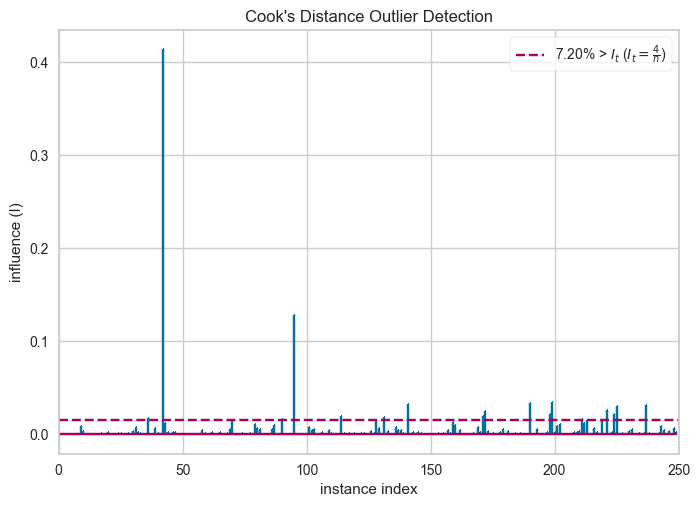

In [21]:
plot_model(tuned_KNN_model, plot = 'cooks')

In [22]:
plot_model(tuned_KNN_model, plot = 'feature')

TypeError: Feature Importance and RFE plots not available for estimators that doesnt support coef_ or feature_importances_ attribute.

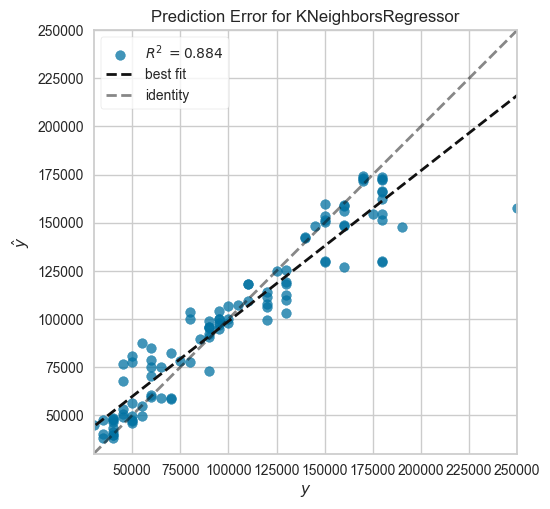

In [23]:
plot_model(tuned_KNN_model, plot = 'error')

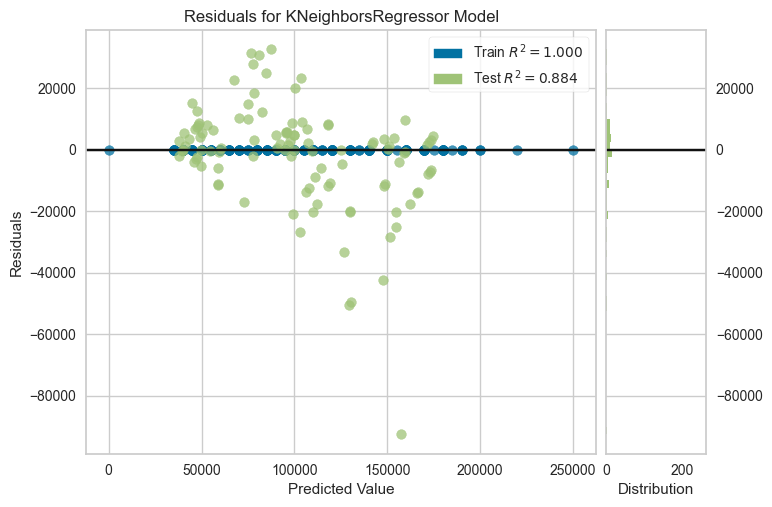

In [24]:
plot_model(tuned_KNN_model)

In [25]:
interpret_model(tuned_KNN_model)

TypeError: This function only supports tree based models for binary classification: lightgbm, rf, et, xgboost, dt.

In [26]:
predict_model(tuned_KNN_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,11071.2695,295041480.6700,17176.7715,0.8842,0.1693,0.1246


,id,Age,Gender,Education Level,Job Title,Years of Experience,Salary,prediction_label
154,154,37.0,Female,Master's,Senior Marketing Analyst,9.0,95000.0,97779.099
307,307,31.0,Male,Bachelor's,Junior Operations Analyst,3.0,50000.0,56333.525
107,107,36.0,Male,Bachelor's,IT Support Specialist,7.0,60000.0,84876.842
279,279,49.0,Female,Master's,Director of Operations,21.0,180000.0,172193.562
61,61,29.0,Male,Bachelor's,Marketing Analyst,3.0,50000.0,49823.969
...,...,...,...,...,...,...,...,...
29,29,33.0,Male,Master's,Product Designer,6.0,90000.0,95742.523
151,151,36.0,Male,Master's,Senior Business Development Manager,11.0,120000.0,107613.798
72,72,45.0,Male,PhD,Research Director,16.0,190000.0,147728.058
188,188,50.0,Female,PhD,Director of Sales and Marketing,22.0,180000.0,154725.874


In [27]:
final_KNN_model = finalize_model(tuned_KNN_model)

In [28]:
predict_model(final_KNN_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,K Neighbors Regressor,8206.9758,171102056.1096,13080.5985,0.9328,0.1296,0.0931


,id,Age,Gender,Education Level,Job Title,Years of Experience,Salary,prediction_label
154,154,37.0,Female,Master's,Senior Marketing Analyst,9.0,95000.0,96552.507
307,307,31.0,Male,Bachelor's,Junior Operations Analyst,3.0,50000.0,53919.243
107,107,36.0,Male,Bachelor's,IT Support Specialist,7.0,60000.0,80123.087
279,279,49.0,Female,Master's,Director of Operations,21.0,180000.0,174910.476
61,61,29.0,Male,Bachelor's,Marketing Analyst,3.0,50000.0,48730.604
...,...,...,...,...,...,...,...,...
29,29,33.0,Male,Master's,Product Designer,6.0,90000.0,95966.613
151,151,36.0,Male,Master's,Senior Business Development Manager,11.0,120000.0,113238.801
72,72,45.0,Male,PhD,Research Director,16.0,190000.0,157260.236
188,188,50.0,Female,PhD,Director of Sales and Marketing,22.0,180000.0,160385.374


In [29]:
save_model(final_KNN_model,'../model/20250517_final_KNN_model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('numerical_imputer',
                  TransformerWrapper(include=['id', 'Age',
                                              'Years of Experience'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['Gender', 'Job Title',
                                              'Education Level'],
                                     transformer=SimpleImputer(strategy='most_frequent'))),
                 ('ordinal_encoding',
                  TransformerWrapper(include=['Ge...
                  TransformerWrapper(include=['Job Title'],
                                     transformer=TargetEncoder(cols=['Job '
                                                                     'Title'],
                                                               handle_missing='return_nan'))),
                 ('normalize', TransformerWrapper(trans